In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from datetime import datetime
from datetime import timedelta  
from sklearn.model_selection import train_test_split

In [2]:
DATA_DIR = 'wenet_data/'

In [3]:
profiles = pd.read_csv(f'{DATA_DIR}m35_profiles.csv')
user_data = pd.read_csv(f'{DATA_DIR}m35_data.csv')

# remove etc from actions
user_data = user_data[~user_data['Action_type'].eq('etc')]
user_data['Action_type'] = user_data['Action_type'].fillna('No Action')
# rename user ID columns to fit both datasets
user_data = user_data.rename({'user_id': 'userid'}, axis=1)
# create user reward series
user_reward = user_data.groupby('userid').size().to_frame('reward')
# joint dataset
data = profiles.join(user_reward, on='userid')
# removing irrelevant columns
columns_to_remove = ['appId']
data = data.drop(columns_to_remove, axis=1)
data.head()

,userid,gender,locale,nationality,creationTs,lastUpdateTs,dateOfBirth - year,department,degree_programme,university,...,c_locfac,u_active,u_read,u_essay,u_org,u_balance,u_assess,u_theory,u_pract,reward
0,477,M,it_IT,italy,1638288097,1638288380,1999.0,Information Engineering and Computer Science,MSc/MA,UNITN,...,0.50,0.50,0.75,0.25,0.25,0.25,0.25,0.25,0.50,7.0
1,483,M,it_IT,italy,1638368024,1638464635,1999.0,Information Engineering and Computer Science,MSc/MA,UNITN,...,0.50,0.50,0.25,0.25,0.25,0.50,0.50,0.50,0.50,8.0
2,487,F,it_IT,NaN,1638440980,1639040411,2000.0,Mathematics,Undergraduate year 3,UNITN,...,0.25,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.0
3,509,M,en_US,NaN,1638850986,1638851844,1991.0,Information Engineering and Computer Science,Undergraduate year 1,UNITN,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.0
4,472,M,it_IT,NaN,1638278371,1638279475,2000.0,Industrial Engineering,Undergraduate year 3,UNITN,...,0.75,0.50,0.50,0.25,0.25,0.75,0.50,0.50,0.75,20.0


### Categorical columns into numerical

In [4]:
for col in data.select_dtypes('object').columns:
    data[col] = data[col].astype('category').cat.codes
data.head()

,userid,gender,locale,nationality,creationTs,lastUpdateTs,dateOfBirth - year,department,degree_programme,university,...,c_locfac,u_active,u_read,u_essay,u_org,u_balance,u_assess,u_theory,u_pract,reward
0,477,1,11,8,1638288097,1638288380,1999.0,21,4,4,...,0.50,0.50,0.75,0.25,0.25,0.25,0.25,0.25,0.50,7.0
1,483,1,11,8,1638368024,1638464635,1999.0,21,4,4,...,0.50,0.50,0.25,0.25,0.25,0.50,0.50,0.50,0.50,8.0
2,487,0,11,-1,1638440980,1639040411,2000.0,26,11,4,...,0.25,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.0
3,509,1,4,-1,1638850986,1638851844,1991.0,21,9,4,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.0
4,472,1,11,-1,1638278371,1638279475,2000.0,20,11,4,...,0.75,0.50,0.50,0.25,0.25,0.75,0.50,0.50,0.75,20.0


### Handle Nan rows

In [5]:
# Remove rows with no rewrad
data = data[~data['reward'].isna()]
data = data.fillna(data.mean())
# check for na
print(f'is there na left? {(data.isna().sum().sum() == 0)}')

is there na left? True


### Feautres coefficients - Linear Regression

In [6]:
X = data.iloc[: , 1:-1]
y = data.iloc[: , -1:]
print(X.shape)
print(y.shape)

(157, 43)
(157, 1)


In [7]:
reg = LinearRegression()
reg.fit(X, y)

LinearRegression()

In [8]:
coefficients = list(zip(X.columns, reg.coef_[0]))
coefficients.sort(key=lambda x: x[1])

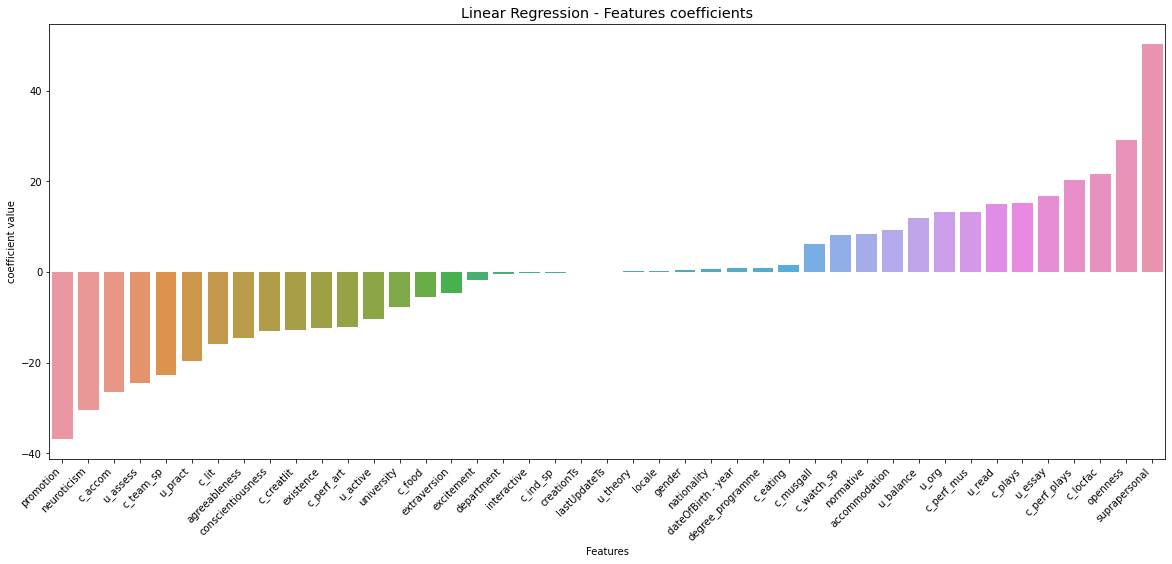

In [9]:
fig, ax = plt.subplots(figsize=(20, 8))

plt.rcParams.update({'font.size': 12})
ax.set_title('Linear Regression - Features coefficients')
ax.set_xlabel('Features')
ax.set_ylabel('coefficient value')
sns.barplot(x= [x[0] for x in coefficients], y=[x[1] for x in coefficients], ax=ax)
plt.xticks(rotation=45, ha='right')
plt.show()

### XGBoost

In [10]:
from xgboost import XGBRegressor

In [11]:
xgb = XGBRegressor()

In [12]:
xgb.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [13]:
feature_importance = list(zip(X.columns, xgb.feature_importances_))
feature_importance.sort(key=lambda x: x[1])

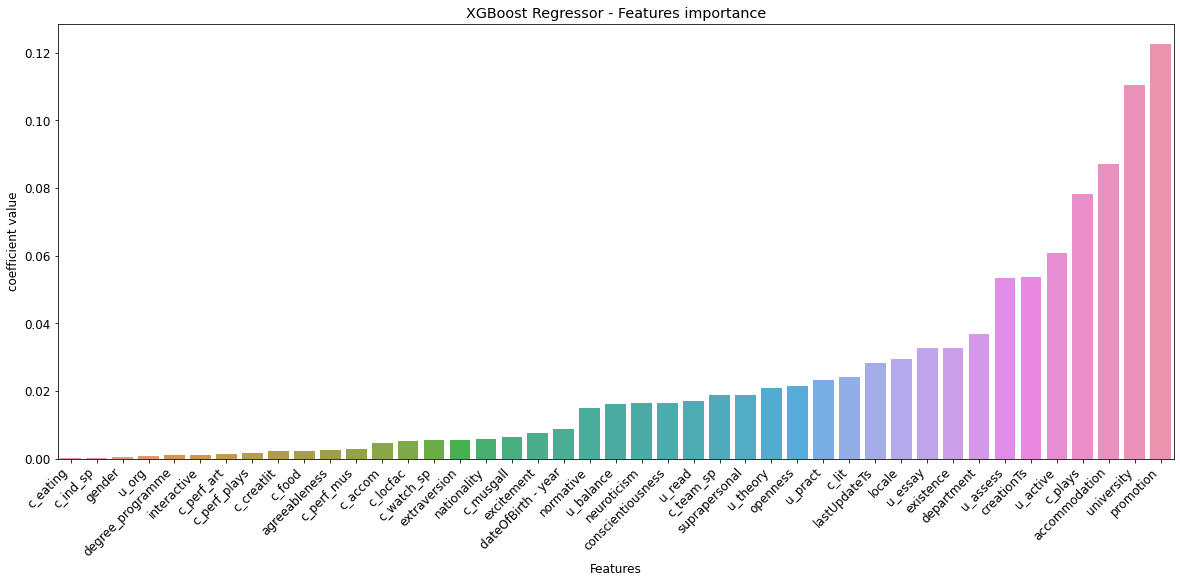

In [14]:
fig, ax = plt.subplots(figsize=(20, 8))

plt.rcParams.update({'font.size': 12})
ax.set_title('XGBoost Regressor - Features importance')
ax.set_xlabel('Features')
ax.set_ylabel('coefficient value')
sns.barplot(x= [x[0] for x in feature_importance], y=[x[1] for x in feature_importance], ax=ax)
plt.xticks(rotation=45, ha='right')
plt.show()

### Pure correlation

In [15]:
correlations = {}
for m in ["pearson", "kendall", "spearman"]:
    correlations[m] = data.iloc[:, 1:].corr(method=m)['reward'].sort_values()
correlations_df = pd.DataFrame(correlations)

In [16]:
correlations_df.drop(['reward'],axis = 0,inplace=True)

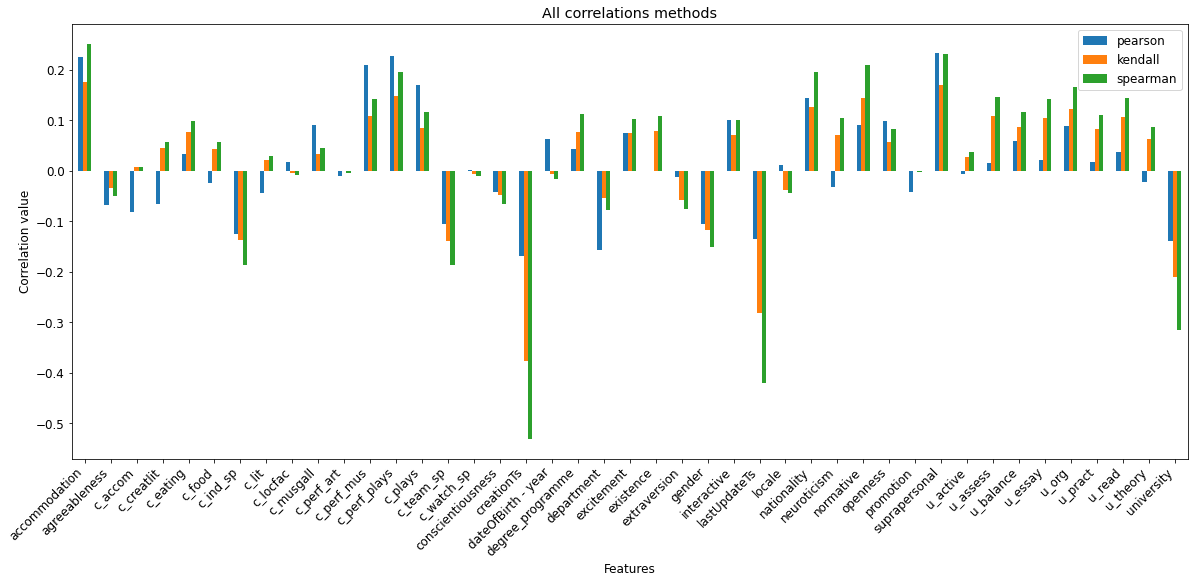

In [17]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.set_title('All correlations methods')
ax.set_xlabel('Features')
ax.set_ylabel('Correlation value')
correlations_df.plot.bar(ax=ax)
plt.xticks(rotation=45, ha='right')
plt.show()

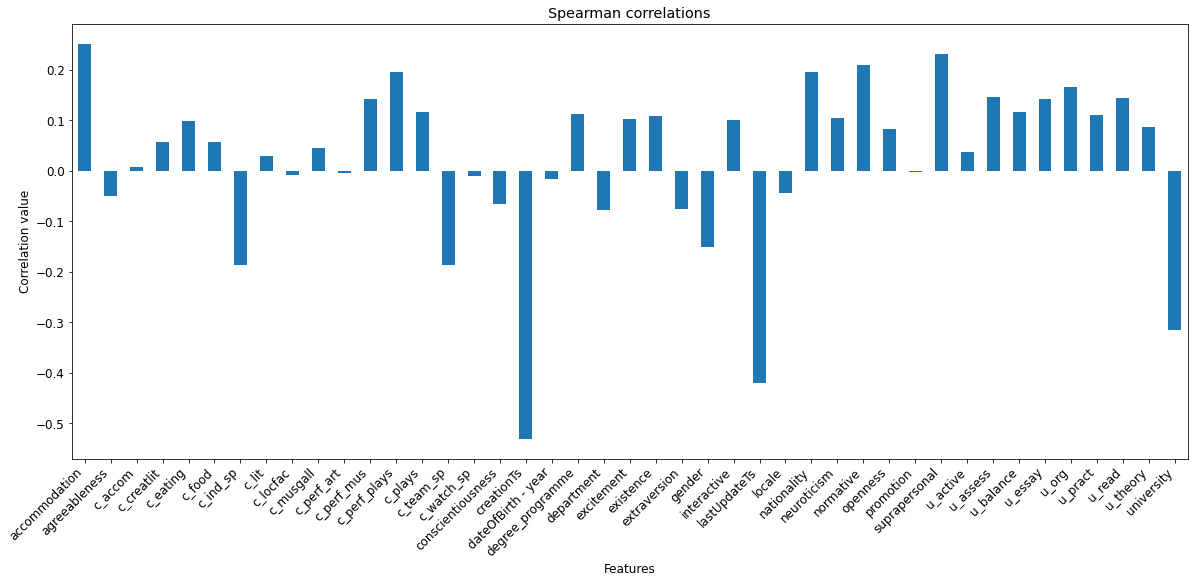

In [18]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.set_title('Spearman correlations')
ax.set_xlabel('Features')
ax.set_ylabel('Correlation value')
correlations_df['spearman'].plot.bar(ax=ax)
plt.xticks(rotation=45, ha='right')
plt.show()

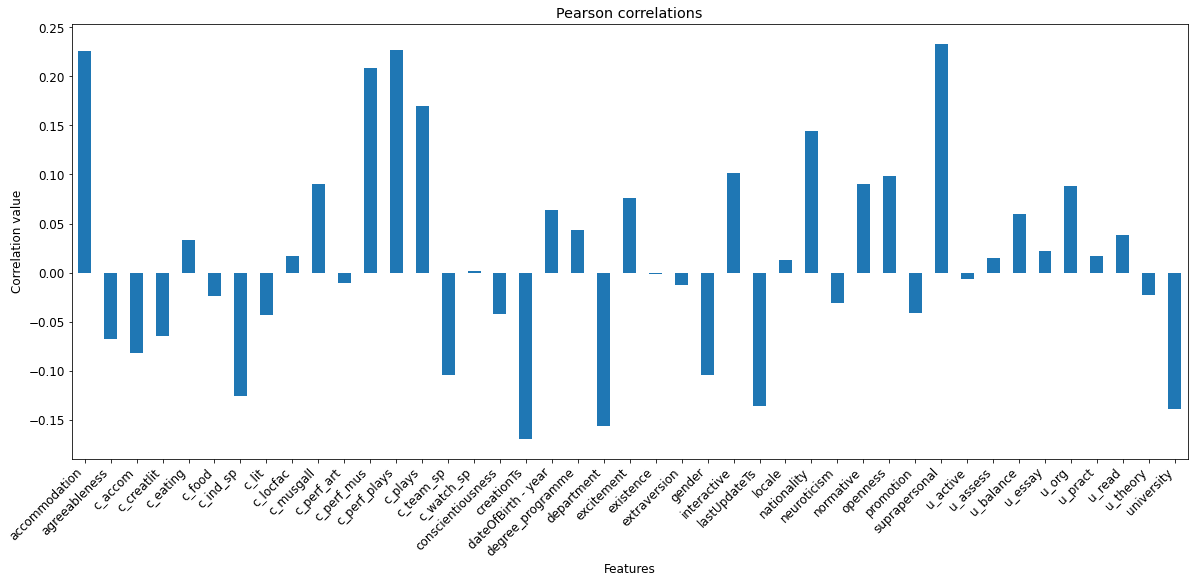

In [19]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.set_title('Pearson correlations')
ax.set_xlabel('Features')
ax.set_ylabel('Correlation value')
correlations_df['pearson'].plot.bar(ax=ax)
plt.xticks(rotation=45, ha='right')
plt.show()

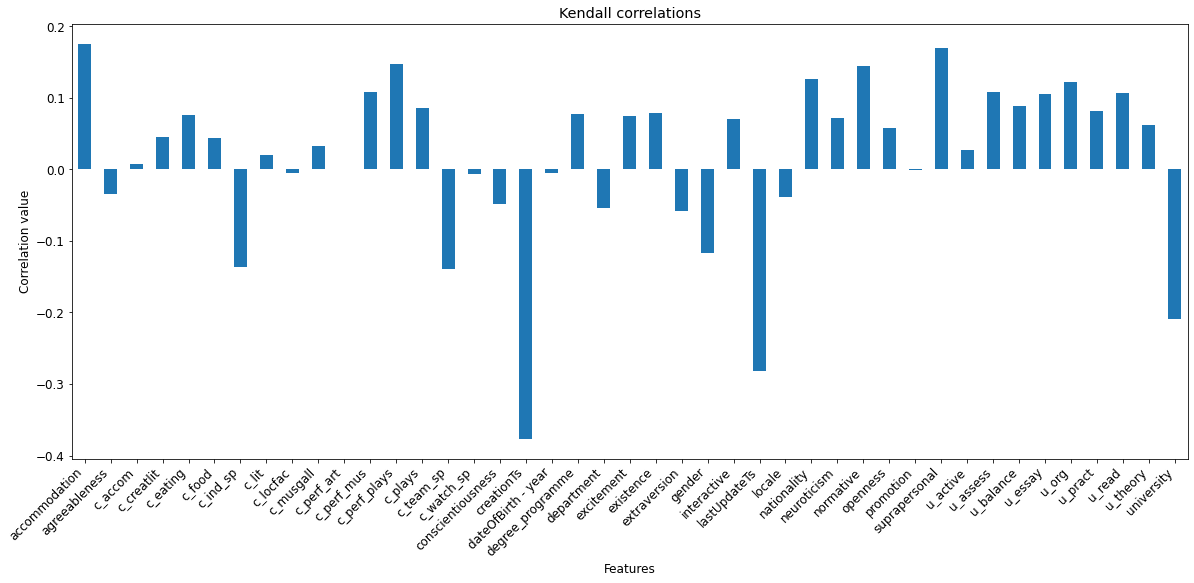

In [20]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.set_title('Kendall correlations')
ax.set_xlabel('Features')
ax.set_ylabel('Correlation value')
correlations_df['kendall'].plot.bar(ax=ax)
plt.xticks(rotation=45, ha='right')
plt.show()

### Big five analysis

In [21]:
def create_feature_corr(columns, method):
    features_profiles_df = profiles[['userid'] +columns]
    user_actions = user_data.groupby(['userid'])['Action_type'].value_counts().unstack().fillna(0)
    user_actions = user_actions.drop(columns=['No Action'])
    user_actions['overall_reward'] = user_actions.apply(lambda row: row.sum(), axis=1)
    features_with_actions = features_profiles_df.join(user_actions, on='userid')
    features_with_actions = features_with_actions.drop(columns=['userid'])  # No need for user id in the graphs
    features_with_actions = features_with_actions.fillna(features_with_actions.mean())
    corr_table = features_with_actions.corr(method=method)[columns].drop(columns, axis=0)
    return corr_table, features_with_actions

In [22]:
big_five_columns = ['extraversion', 'agreeableness', 'openness', 'conscientiousness', 'neuroticism']
method = 'pearson'
corr_table, big_five_with_actions = create_feature_corr(big_five_columns, method)

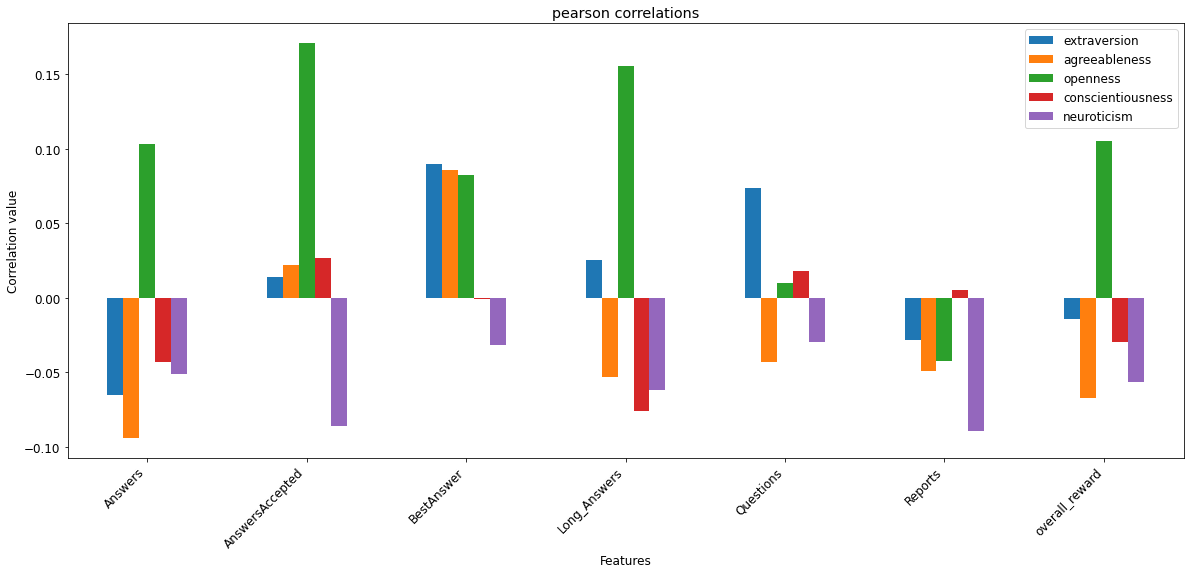

In [23]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.set_title(f'{method} correlations')
ax.set_xlabel('Features')
ax.set_ylabel('Correlation value')
corr_table.plot.bar(ax=ax)
plt.rcParams.update({'font.size': 12})

plt.xticks(rotation=45, ha='right')
plt.show()

In [24]:
rewards_columns = big_five_with_actions.iloc[: , 5:].columns

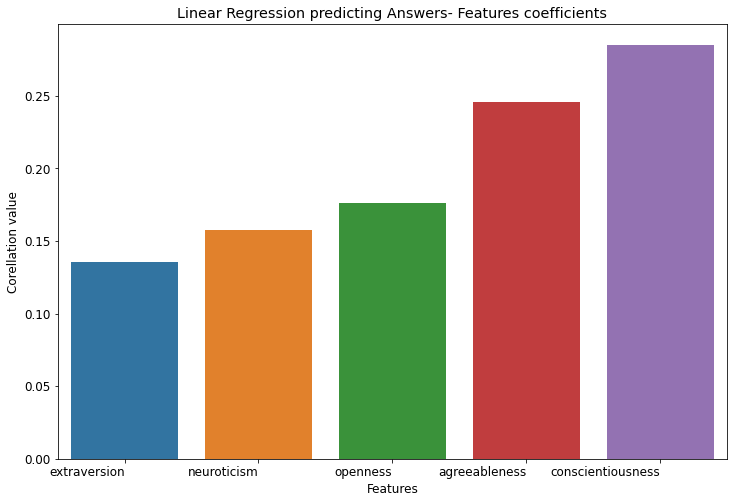

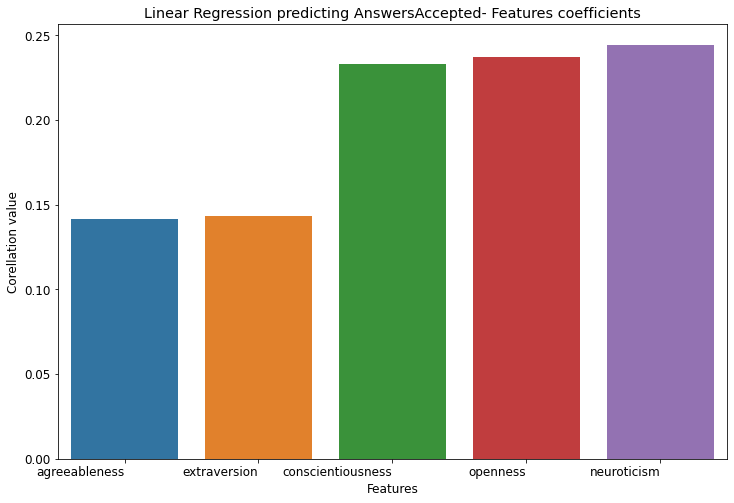

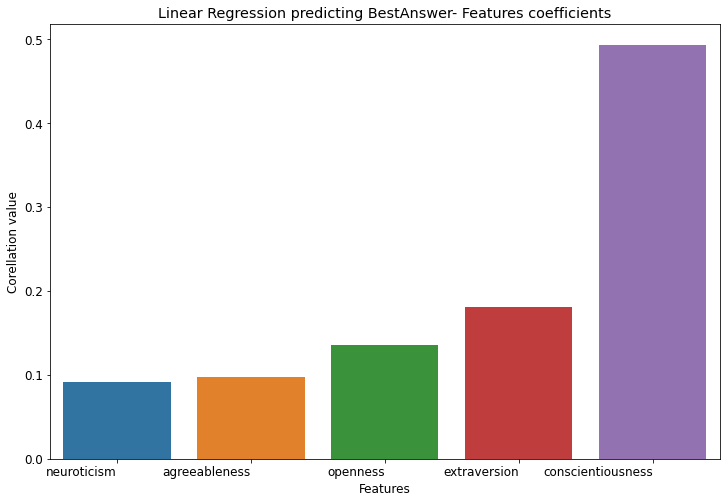

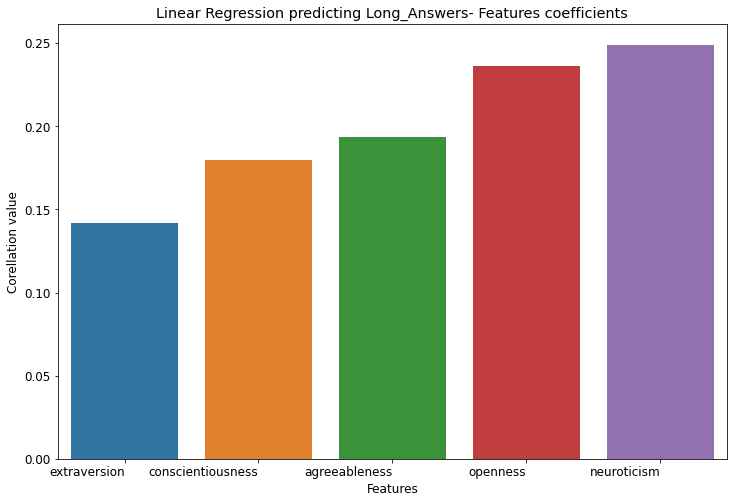

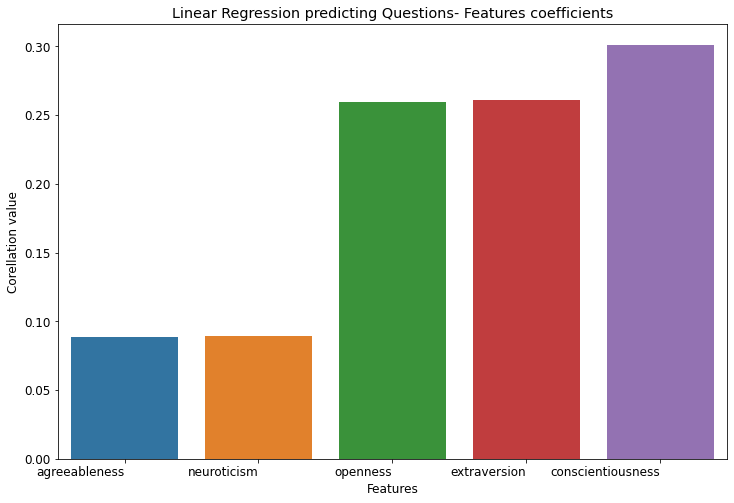

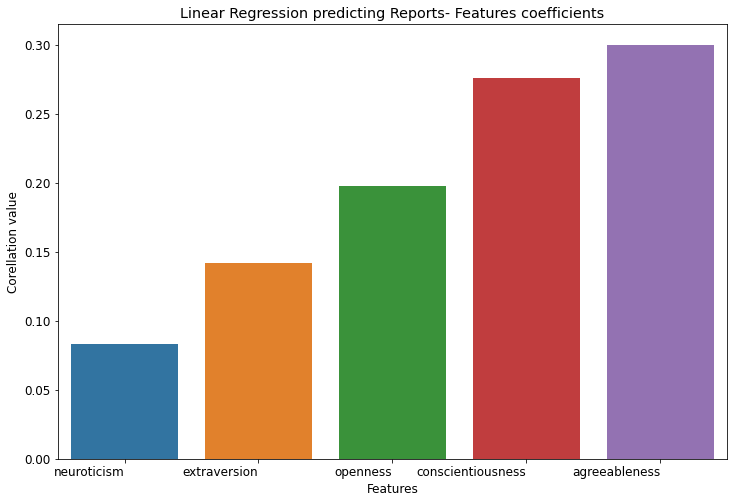

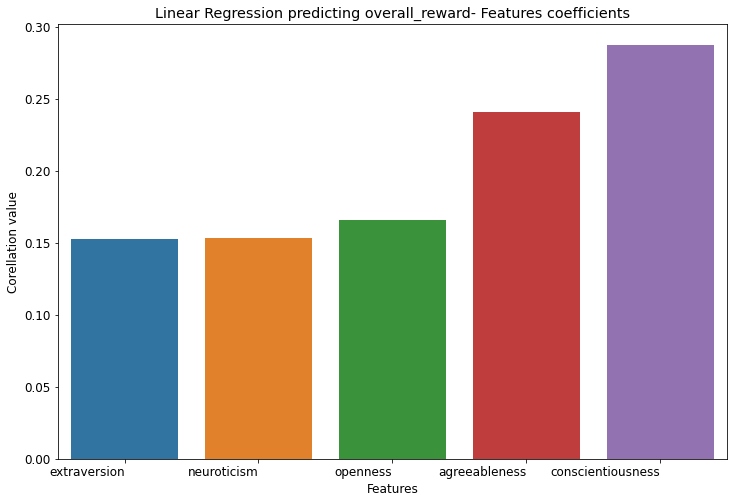

In [25]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split
for i in range(len(rewards_columns)):
    y_column = rewards_columns[i]
    X = big_five_with_actions.iloc[: , : 5]
    y = big_five_with_actions[y_column]
    

    reg = XGBRegressor(booster='gbtree')
    reg.fit(X, y)
    coefficients = list(zip(X.columns, reg.feature_importances_))
    coefficients.sort(key=lambda x: x[1])

    fig, ax = plt.subplots(figsize=(12, 8))

    plt.rcParams.update({'font.size': 12})
    ax.set_title(f'Linear Regression predicting {y_column}- Features coefficients')
    ax.set_xlabel('Features')
    ax.set_ylabel('Corellation value')
    sns.barplot(x= [x[0] for x in coefficients], y=[x[1] for x in coefficients], ax=ax)
    plt.xticks(rotation=0, ha='right')
    plt.show()

### correlation analysis for 5 other features

In [26]:
team_ori_columns = ['c_team_sp', 'c_eating', 'c_perf_mus', 'c_perf_plays']
method = 'pearson'
corr_table, team_features_with_actions = create_feature_corr(team_ori_columns, method)

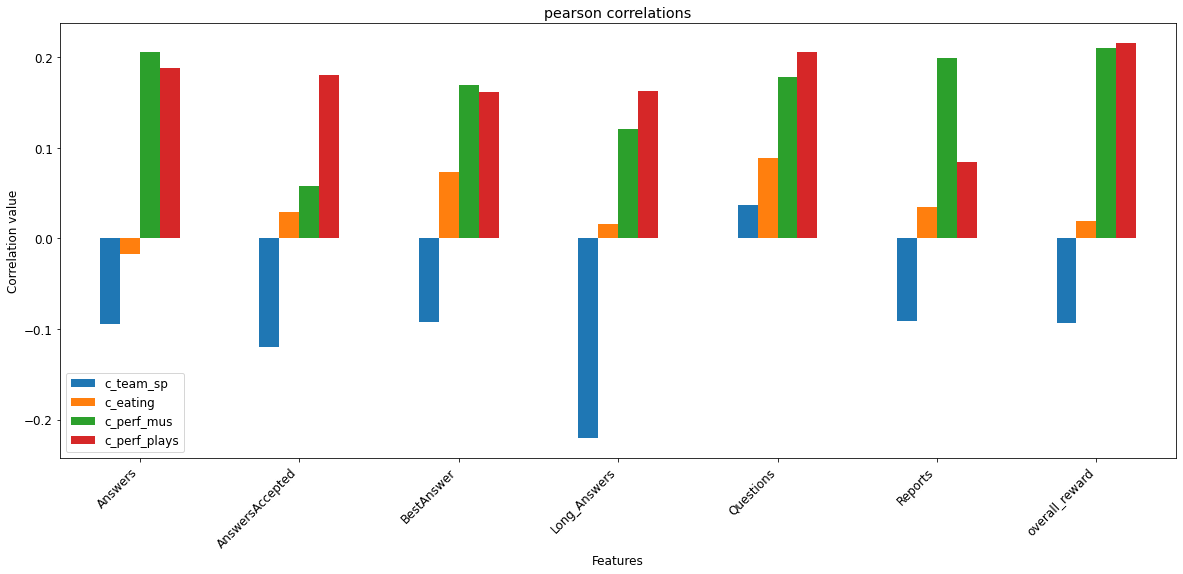

In [27]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.set_title(f'{method} correlations')
ax.set_xlabel('Features')
ax.set_ylabel('Correlation value')
corr_table.plot.bar(ax=ax)
plt.rcParams.update({'font.size': 12})

plt.xticks(rotation=45, ha='right')
plt.show()

### Relation between user survey to questions asked

In [28]:
tasks_df = pd.read_csv('wenet_data/M35_merged_5pilots_chatbot_tasks.xlsx - M35 merged pilots tasks.csv')
tasks_df = tasks_df[tasks_df['requesterId'].notna()]
tasks_df.head()

,id,taskTypeId,lastUpdateTs,creationTs,requesterId,appId,closeTs,communityId,transactions.taskId,transactions.label,...,goal.name,goal.description,attributes.domain,attributes.domainInterest,attributes.beliefsAndValues,attributes.sensitive,attributes.anonymous,attributes.socialCloseness,attributes.positionOfAnswerer,attributes.maxUsers
0,619b9aa959410d1c776ddf15,618d504ed844da03b28cc4bf,2021-11-22,2021-11-22,211.0,HnH5iaO6VI,2021-11-22,618e45a7af7f96368a125e12,619b9aa959410d1c776ddf15,CREATE_TASK,...,"Hola a todos, quería saber quienes participan ...",NaN,varia_misc,indifferent,indifferent,False,False,indifferent,anywhere,15.0
6,619ba35b59410d1c776ddf19,618d504ed844da03b28cc4bf,2021-11-23,2021-11-22,410.0,HnH5iaO6VI,2021-11-23,618e45a7af7f96368a125e12,619ba35b59410d1c776ddf19,CREATE_TASK,...,3 principios para estudiar efectivamente con c...,NaN,studying_career,indifferent,similar,False,False,indifferent,anywhere,15.0
12,619ba62f59410d1c776ddf1a,618d504ed844da03b28cc4bf,2021-11-22,2021-11-22,22.0,HnH5iaO6VI,2021-11-22,618e45a7af7f96368a125e12,619ba62f59410d1c776ddf1a,CREATE_TASK,...,Hola?,NaN,varia_misc,indifferent,different,False,False,indifferent,anywhere,15.0
16,619ba6f659410d1c776ddf1b,618d504ed844da03b28cc4bf,2021-11-22,2021-11-22,410.0,HnH5iaO6VI,2021-11-22,618e45a7af7f96368a125e12,619ba6f659410d1c776ddf1b,CREATE_TASK,...,Las preguntas y respuestas vienen con una firm...,NaN,varia_misc,indifferent,indifferent,False,False,indifferent,anywhere,15.0
21,619bc11a59410d1c776ddf25,618d504ed844da03b28cc4bf,2021-11-22,2021-11-22,355.0,HnH5iaO6VI,2021-11-22,618e45a7af7f96368a125e12,619bc11a59410d1c776ddf25,CREATE_TASK,...,Cuál es la capital de Afganistán?,NaN,local_things,similar,similar,False,False,indifferent,anywhere,15.0


In [29]:
user_domains = tasks_df.groupby('requesterId')['attributes.domain'].apply(list).to_frame('domains').reset_index()
user_domains.domains = user_domains.domains.apply(lambda x: pd.Series(x).value_counts().to_dict())
user_domains = pd.concat([user_domains.drop('domains', axis=1), pd.DataFrame(user_domains['domains'].tolist())], axis=1)
user_domains = user_domains.fillna(0)
user_domains = user_domains.set_index('requesterId')
user_domains

,local_things,music,varia_misc,cinema_theatre,food_and_cooking,local_university,life_ponders,studying_career,cultural_interests,physical_activity,arts_and_crafts
requesterId,,,,,,,,,,,
5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
49.0,0.0,0.0,1.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
505.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
507.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
508.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


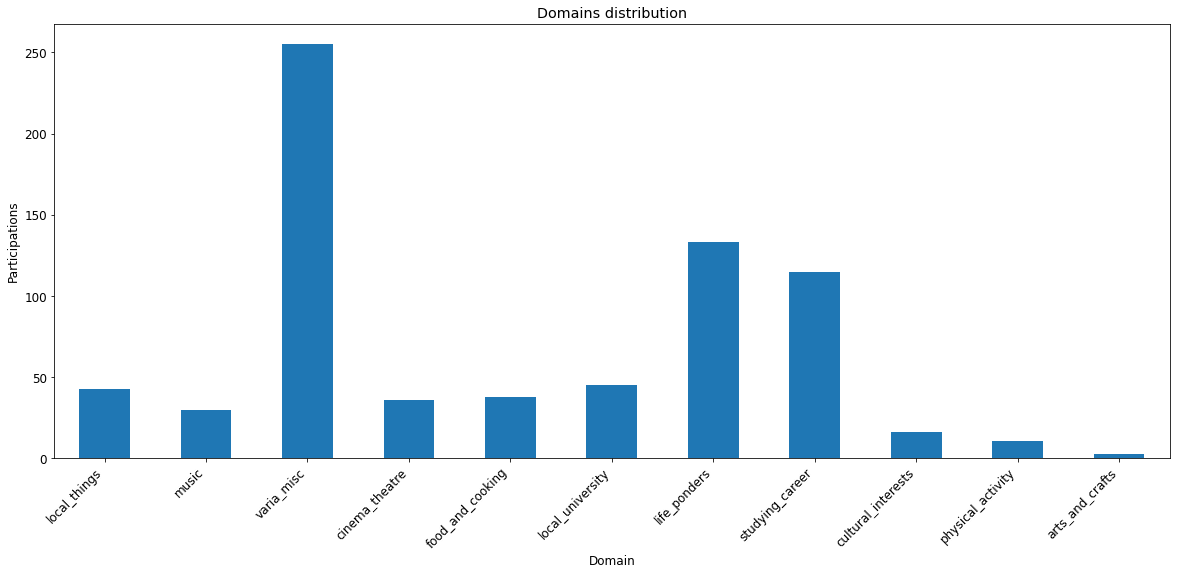

In [30]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.set_title('Domains distribution')
ax.set_xlabel('Domain')
ax.set_ylabel('Participations')
user_domains.sum().plot.bar(ax=ax)
plt.xticks(rotation=45, ha='right')
plt.show()

In [31]:
hobbies_domains = ['music', 'cinema_theatre', 'food_and_cooking', 'arts_and_crafts', 'physical_activity']
university_domains = ['local_university', 'studying_career']
personal_domains = ['local_things','life_ponders', 'cultural_interests']

In [32]:
user_domains_agg = pd.DataFrame({'hobbies_questions_mean':user_domains[hobbies_domains].mean(1) ,
              'university_questions_mean': user_domains[university_domains].mean(1),
              'personality_questions_mean': user_domains[personal_domains].mean(1)})
user_domains_agg

,hobbies_questions_mean,university_questions_mean,personality_questions_mean
requesterId,,,
5.0,0.0,0.0,0.333333
10.0,0.2,0.0,0.333333
22.0,0.0,0.0,0.000000
40.0,0.4,0.0,0.333333
49.0,0.0,2.0,1.000000
...,...,...,...
505.0,0.0,0.5,0.000000
507.0,0.0,0.0,0.000000
508.0,0.0,0.0,0.333333


In [33]:
user_profiles_domains = profiles[profiles.userid.isin(user_domains.index)]
profile_columns = user_profiles_domains.columns

In [34]:
university_feature_columns = list(profile_columns[[x.startswith('u_') for x in profile_columns.values]].values)
hobbies_feature_columns = list(profile_columns[[x.startswith('c_') for x in profile_columns.values]].values)
personality_feature_columns = ["excitement",
"promotion",
"existence",
"suprapersonal",
"interactive",
"normative",
"extraversion",
"agreeableness",
"conscientiousness",
"neuroticism",
"openness"]

In [35]:
profiles_user_summary = pd.DataFrame({'userid':user_profiles_domains['userid'] ,
              'uni_mean_surv':user_profiles_domains[university_feature_columns].mean(1), 
              'hobbies_mean_surv': user_profiles_domains[hobbies_feature_columns].mean(1),
              'personality_mean_surv': user_profiles_domains[personality_feature_columns].mean(1)})
profiles_user_summary.head()

,userid,uni_mean_surv,hobbies_mean_surv,personality_mean_surv
1,483,0.40625,0.428571,0.628818
3,509,0.00000,0.571429,0.818182
4,472,0.50000,0.553571,0.706182
5,507,0.37500,0.428571,0.574182
7,488,0.75000,0.660714,0.668182


In [36]:
profiles_user_summary = profiles_user_summary.fillna(0)

In [37]:
def distance(x, y):
    if np.isnan(x) or np.isnan(y):
        return 0
    return np.abs(x - y)

In [38]:
user_profile_questions = profiles_user_summary.join(user_domains_agg, on='userid')
user_profile_questions = user_profile_questions.fillna(0)
user_profile_questions

,userid,uni_mean_surv,hobbies_mean_surv,personality_mean_surv,hobbies_questions_mean,university_questions_mean,personality_questions_mean
1,483,0.40625,0.428571,0.628818,0.0,0.0,0.333333
3,509,0.00000,0.571429,0.818182,0.0,0.0,0.333333
4,472,0.50000,0.553571,0.706182,0.4,1.0,0.000000
5,507,0.37500,0.428571,0.574182,0.0,0.0,0.000000
7,488,0.75000,0.660714,0.668182,0.0,1.0,0.000000
...,...,...,...,...,...,...,...
152,412,0.71875,0.607143,0.803000,0.4,0.5,1.333333
153,386,0.56250,0.535714,0.703000,0.6,0.5,1.000000
154,464,0.00000,0.000000,0.000000,0.0,0.0,0.333333
155,440,0.34375,0.410714,0.757545,0.4,1.0,0.333333


In [39]:
d = {
    'uni_mean_surv' : 0, 
    'hobbies_mean_surv': 1, 
    'personality_mean_surv': 2,
    'university_questions_mean': 0,
    'hobbies_questions_mean': 1, 
    'personality_questions_mean': 2
}

def user_survey_match(row):
    user_focus_surv = 0
    user_focus_questions = 0
    surv = ['uni_mean_surv', 'hobbies_mean_surv', 'personality_mean_surv']
    chatbox = ['hobbies_questions_mean', 'university_questions_mean', 'personality_questions_mean']
    user_focus_surv = row[surv].idxmax()
    user_focus_questions = row[chatbox].idxmax()
    return d[user_focus_questions], d[user_focus_surv]  # y_true, y_pred

In [40]:
y_true, y_pred = zip(*user_profile_questions.apply(lambda row: user_survey_match(row), axis=1).values)

In [41]:
cf_matrix = confusion_matrix(y_true, y_pred)

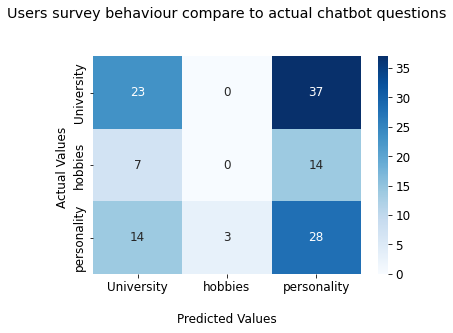

In [42]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Users survey behaviour compare to actual chatbot questions\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['University','hobbies', 'personality'])
ax.yaxis.set_ticklabels(['University','hobbies', 'personality'])

plt.show()

<AxesSubplot:>

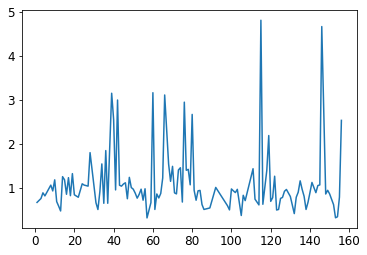

In [43]:
from scipy.spatial import distance

surv = ['uni_mean_surv', 'hobbies_mean_surv', 'personality_mean_surv']
chatbox = ['university_questions_mean', 'hobbies_questions_mean', 'personality_questions_mean']
user_profile_questions.apply(lambda row: distance.euclidean(row[surv], row[chatbox]), axis=1).plot()

### socialCloseness & beliefsAndValues & Position of answerer



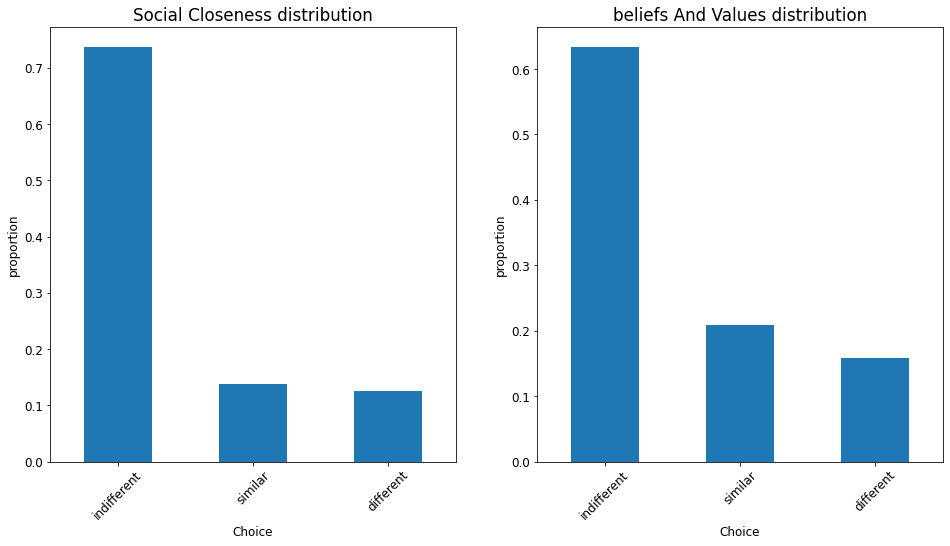

In [44]:
fig, ax = plt.subplots(1 , 2,figsize=(16, 8))
plt.rcParams.update({'font.size': 14})
ax[0].set_title('Social Closeness distribution')
ax[0].set_xlabel('Choice')
ax[0].set_ylabel('proportion')
tasks_df['attributes.socialCloseness'].value_counts(normalize=True).plot.bar(ax=ax[0])
ax[1].set_title('beliefs And Values distribution')
ax[1].set_xlabel('Choice')
ax[1].set_ylabel('proportion')
tasks_df['attributes.beliefsAndValues'].value_counts(normalize=True).plot.bar(ax=ax[1])
ax[0].set_xticklabels(labels=['indifferent', 'similar', 'different'], rotation=45)
ax[1].set_xticklabels(labels=['indifferent', 'similar', 'different'], rotation=45)
plt.show()

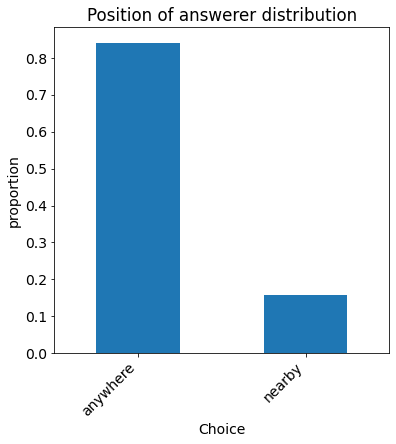

In [45]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.rcParams.update({'font.size': 14})
ax.set_title('Position of answerer distribution')
ax.set_xlabel('Choice')
ax.set_ylabel('proportion')
tasks_df['attributes.positionOfAnswerer'].value_counts(normalize=True).plot.bar(ax=ax)
plt.xticks(rotation=45, ha='right')
plt.show()

### Change in socialCloseness & beliefsAndValues & Position of answerer related to time 

In [46]:
tmp_df = tasks_df[['transactions.creationTs', 'attributes.positionOfAnswerer', 'attributes.beliefsAndValues', 'attributes.socialCloseness']]
tmp_df

,transactions.creationTs,attributes.positionOfAnswerer,attributes.beliefsAndValues,attributes.socialCloseness
0,2021-11-22,anywhere,indifferent,indifferent
6,2021-11-22,anywhere,similar,indifferent
12,2021-11-22,anywhere,different,indifferent
16,2021-11-22,anywhere,indifferent,indifferent
21,2021-11-22,anywhere,similar,indifferent
...,...,...,...,...
4765,2021-12-19,nearby,different,different
4773,2021-12-19,nearby,indifferent,indifferent
4783,2021-12-19,nearby,similar,indifferent
4793,2021-12-20,anywhere,different,different


In [47]:
def change_in_time(df, column, options):
    result = {}
    for option in options:
        result[option] = []
    for date, group in df.groupby('transactions.creationTs'):
        tmp_dict = group[column].value_counts().to_dict()
        for option in options:
            if option in tmp_dict:
                result[option].append(tmp_dict[option])
            else:
                result[option].append(0)
    return result

In [48]:
def plot_change_in_time(df, column, options):
    result_dict = change_in_time(df, column, options)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_title(f'Change in time for {column}')
    ax.set_xlabel('Day number')
    ax.set_ylabel('Number of questions')


    for key in result_dict.keys():
        # poly = np.polyfit(np.arange(len(result_dict[key])),result_dict[key],10)
        # poly_y = np.poly1d(poly)(np.arange(len(result_dict[key])))
        # ax.plot(np.arange(len(result_dict[key])),poly_y)
        ax.plot(result_dict[key], label=f'{key}')
        ax.legend(title = "Choice")
    plt.xticks(rotation=45, ha='right')
    plt.show()

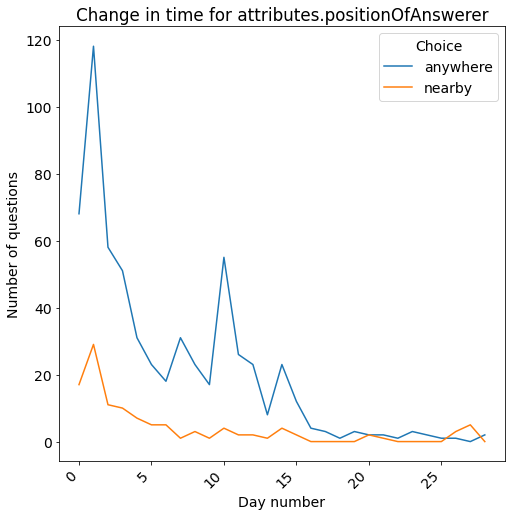

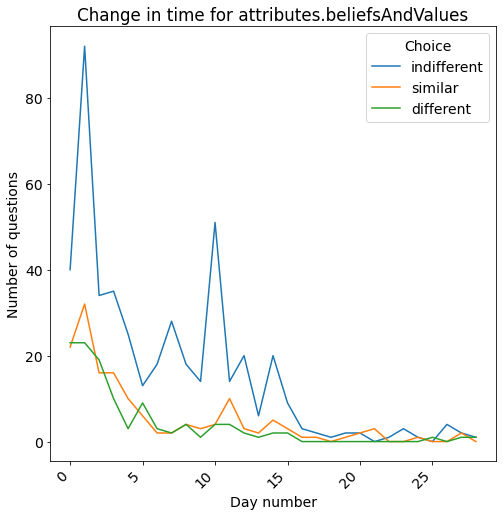

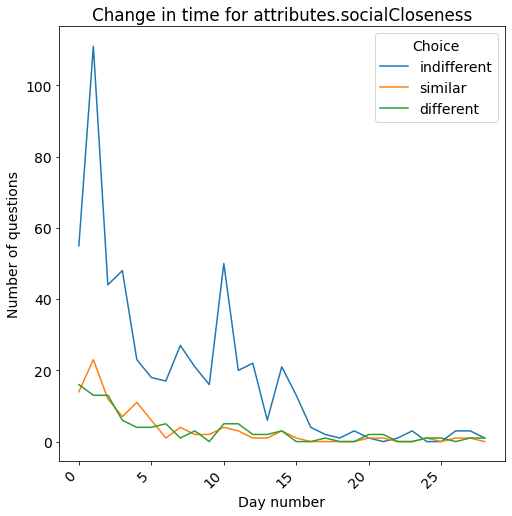

In [49]:
plot_change_in_time(tmp_df, 'attributes.positionOfAnswerer', ['anywhere','nearby'])
plot_change_in_time(tmp_df, 'attributes.beliefsAndValues', ['indifferent', 'similar', 'different'])
plot_change_in_time(tmp_df, 'attributes.socialCloseness', ['indifferent', 'similar', 'different'])

In [50]:
tmp_df = tasks_df[['attributes.domain', 'attributes.beliefsAndValues']].groupby(['attributes.domain', 'attributes.beliefsAndValues']).size().to_frame('size').reset_index()
tmp_df.head()

,attributes.domain,attributes.beliefsAndValues,size
0,arts_and_crafts,indifferent,2
1,arts_and_crafts,similar,1
2,cinema_theatre,different,3
3,cinema_theatre,indifferent,25
4,cinema_theatre,similar,8


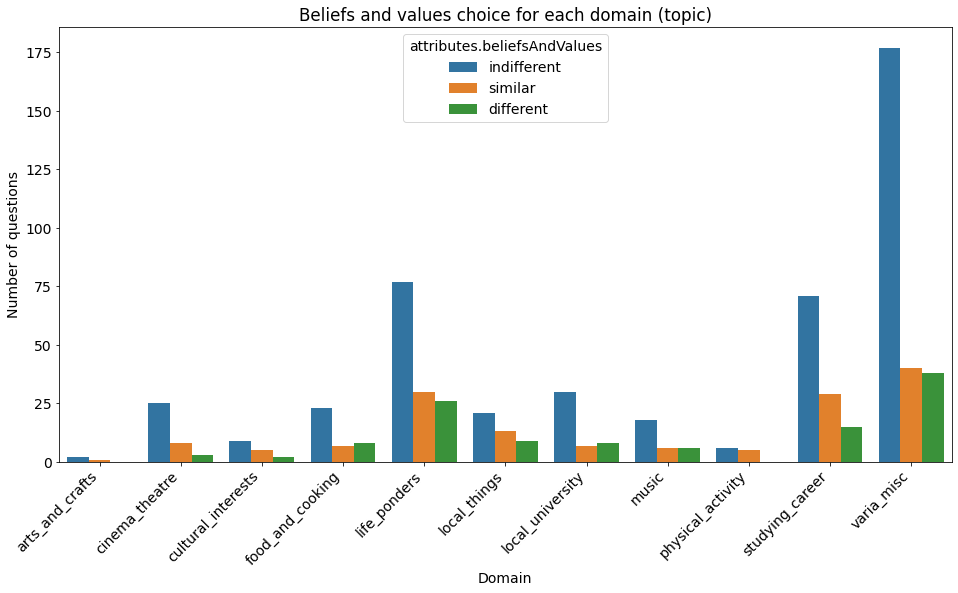

In [51]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x="attributes.domain", y="size", hue="attributes.beliefsAndValues", data=tmp_df, ci=None, ax=ax)
ax.set_title(f'Beliefs and values choice for each domain (topic)')
ax.set_ylabel('Number of questions')
ax.set_xlabel('Domain')
plt.xticks(rotation=45, ha='right')
plt.show()

### Regression Model for Big-five features and incentive

In [52]:
def split_by_date(df, train_days=7):
    first_day = df['created'].min()+timedelta(days=train_days)
    return df[df['created'] <= first_day] , df[df['created'] > first_day]

In [53]:
no_badges = user_data[~user_data['type'].eq('badge')]
no_badges['created'] = pd.to_datetime(no_badges['created'])
no_badges = pd.concat([no_badges, pd.get_dummies(no_badges.location, prefix='country_')], axis=1, join="inner")
no_badges

C:\Anaconda3\envs\msrs\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,created,userid,location,Action_type,type,badge_name,messege_name,country__Copenhagen,country__London,country__Mongolia,country__Paraguay,country__Trento
0,2021-12-07 12:43:58.057853,5,Trento,Questions,NaN,NaN,NaN,0,0,0,0,1
2,2021-12-07 13:09:23.057030,5,Trento,BestAnswer,NaN,NaN,NaN,0,0,0,0,1
3,2021-12-09 13:55:23.111723,5,Trento,Answers,NaN,NaN,NaN,0,0,0,0,1
4,2021-12-09 13:55:24.136502,5,Trento,Long_Answers,NaN,NaN,NaN,0,0,0,0,1
7,2021-11-17 14:01:25.472879,8,Mongolia,Questions,NaN,NaN,NaN,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6697,2021-12-07 17:45:24.170405,510,Trento,AnswersAccepted,NaN,NaN,NaN,0,0,0,0,1
6698,2021-12-07 20:26:32.188119,510,Trento,Answers,NaN,NaN,NaN,0,0,0,0,1
6699,2021-12-07 20:26:33.140123,510,Trento,Long_Answers,NaN,NaN,NaN,0,0,0,0,1
6700,2021-12-07 20:27:58.771513,510,Trento,Answers,NaN,NaN,NaN,0,0,0,0,1


In [54]:
tmp_profiles = profiles.join(location_one_hot, on='userid', how='inner')

NameError: name 'location_one_hot' is not defined

In [ ]:
def run_xgb(features, folds = 10):
    feature_importance = []
    for i in range(folds):
        train, test = split_by_date(no_badges, 17)
        # print('~~~~~~~~ Initial split before groupby user ~~~~~~~~')
        # print(f' train: {train.shape}')
        # print(f' test: {test.shape}')
        user_msgs = train.groupby('userid').agg(messages = ('type', lambda x: np.count_nonzero(np.array(x) == 'message')))
        train = train[~train.Action_type.eq('No Action')]
        train_no_big_five = user_msgs.join(train.groupby('userid').size().to_frame('size'), how='inner')
        train = tmp_profiles.join(train_no_big_five, on='userid', how='right')[['userid'] + features + ['messages']]
        train = train.fillna(0)
        train = train.set_index('userid')
        test = test.groupby('userid').size().to_frame('size')
        tmp = train.join(test)
        tmp = tmp.fillna(0)
        X = tmp.iloc[: , : -1]
        y = tmp.iloc[: , -1:]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        # print('~~~~~~~~ train/test split after groupby user ~~~~~~~~')
        # print(f' train: {X_train.shape}')
        # print(f' test: {X_test.shape}')
        xgb = XGBRegressor(n_estimators=200)
        xgb.fit(X_train, y_train)
        # print(f'train mse: {mean_squared_error(y_train, xgb.predict(X_train))}')
        # print(f'test mse: {mean_squared_error(y_test, xgb.predict(X_test))}')
        feature_importance.append(xgb.feature_importances_)
    feature_importance = list(zip(train.columns, np.array(feature_importance).mean(0)))
    feature_importance.sort(key=lambda x: x[1])
    fig, ax = plt.subplots(figsize=(20, 8))

    plt.rcParams.update({'font.size': 12})
    ax.set_title('XGBoost Regressor - Features importance')
    ax.set_xlabel('Features')
    ax.set_ylabel('coefficient value')
    sns.barplot(x= [x[0] for x in feature_importance], y=[x[1] for x in feature_importance], ax=ax)
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [ ]:
run_xgb(big_five_columns, folds=10)

In [ ]:
features = ['openness', 'extraversion', 'c_eating', 'c_perf_mus' , 'country__Copenhagen', 'country__London', 'country__Mongolia', 'country__Paraguay', 'country__Trento']
run_xgb(features)

### Big five correlation for each of the domains

In [55]:
user_domain_data = user_domains.reset_index()
user_domain_data.head()

,requesterId,local_things,music,varia_misc,cinema_theatre,food_and_cooking,local_university,life_ponders,studying_career,cultural_interests,physical_activity,arts_and_crafts
0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,22.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,40.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,49.0,0.0,0.0,1.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,0.0


In [60]:
big_five_profiles = profiles[['userid'] + big_five_columns+['c_perf_mus', 'c_eating']]
big_five_profiles.head()

,userid,extraversion,agreeableness,openness,conscientiousness,neuroticism,c_perf_mus,c_eating
0,477,0.85,0.65,0.60,0.60,0.60,0.00,0.50
1,483,0.50,0.75,0.60,0.60,0.40,0.25,0.75
2,487,0.20,0.70,0.40,0.95,0.85,0.00,0.25
3,509,1.00,1.00,1.00,1.00,0.60,0.00,0.00
4,472,0.80,0.95,0.65,0.60,0.50,0.75,0.50


In [61]:
def plot_feature_highlow_domains(feature, outlier_threshold):

    # sums users with high/low value in said feature
    high_value_users = big_five_profiles[big_five_profiles[feature] >= 1 - outlier_threshold]
    high_value_users_ids = high_value_users.userid.values

    low_value_users = big_five_profiles[big_five_profiles[feature] <= 0 + outlier_threshold]
    low_value_users_ids = low_value_users.userid.values
    # collect the relevant users domains intresnt
    domains_high_dist = user_domain_data[user_domain_data.requesterId.isin(high_value_users_ids)].iloc[:, 1:].sum()
    domains_low_dist = user_domain_data[user_domain_data.requesterId.isin(low_value_users_ids)].iloc[:, 1:].sum()

    tmp_df = pd.concat([domains_high_dist, domains_low_dist], axis=1)
    tmp_df.columns = [f'high {feature}', f'low {feature}']


    fig, ax = plt.subplots(figsize=(16, 8))
    sns.barplot(x="index", y="value", hue="variable", data=tmp_df.reset_index().melt(id_vars='index'), ci=None)
    ax.set_title(f'High/Low {feature} - domains distribution\nhigh values [{1 - outlier_threshold}, {1}]\nlow values [{0}, {0 + outlier_threshold}]')
    ax.set_ylabel('Number of questions in domain')
    ax.set_xlabel('Domain')
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [62]:
big_five_profiles

,userid,extraversion,agreeableness,openness,conscientiousness,neuroticism,c_perf_mus,c_eating
0,477,0.85,0.65,0.60,0.60,0.60,0.00,0.50
1,483,0.50,0.75,0.60,0.60,0.40,0.25,0.75
2,487,0.20,0.70,0.40,0.95,0.85,0.00,0.25
3,509,1.00,1.00,1.00,1.00,0.60,0.00,0.00
4,472,0.80,0.95,0.65,0.60,0.50,0.75,0.50
...,...,...,...,...,...,...,...,...
153,386,0.55,0.85,0.75,0.45,0.60,0.75,0.50
154,464,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155,440,0.55,0.95,0.70,0.55,0.85,0.50,0.75
156,387,0.45,0.80,0.95,0.55,0.70,0.25,0.50


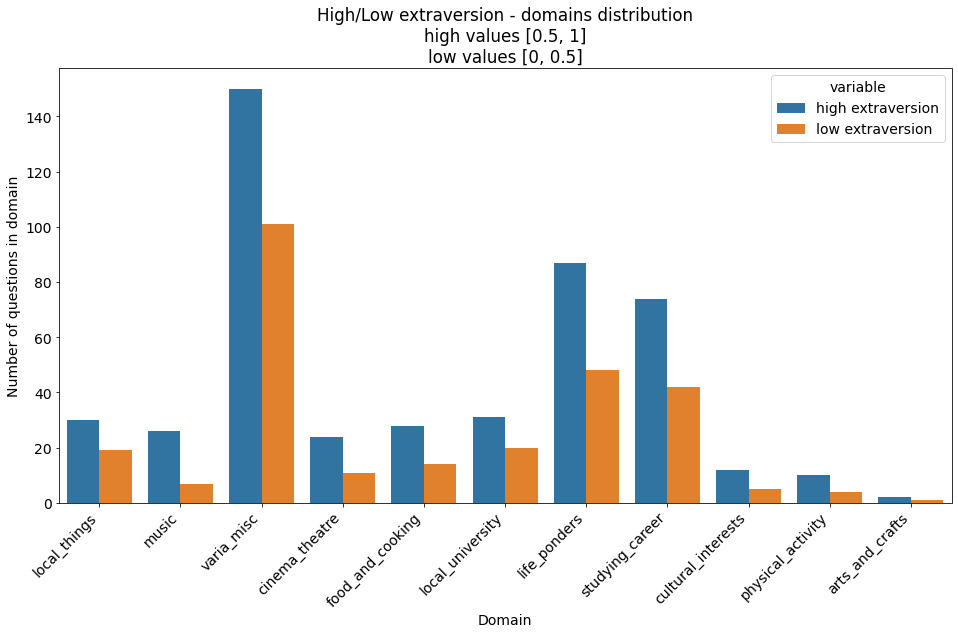

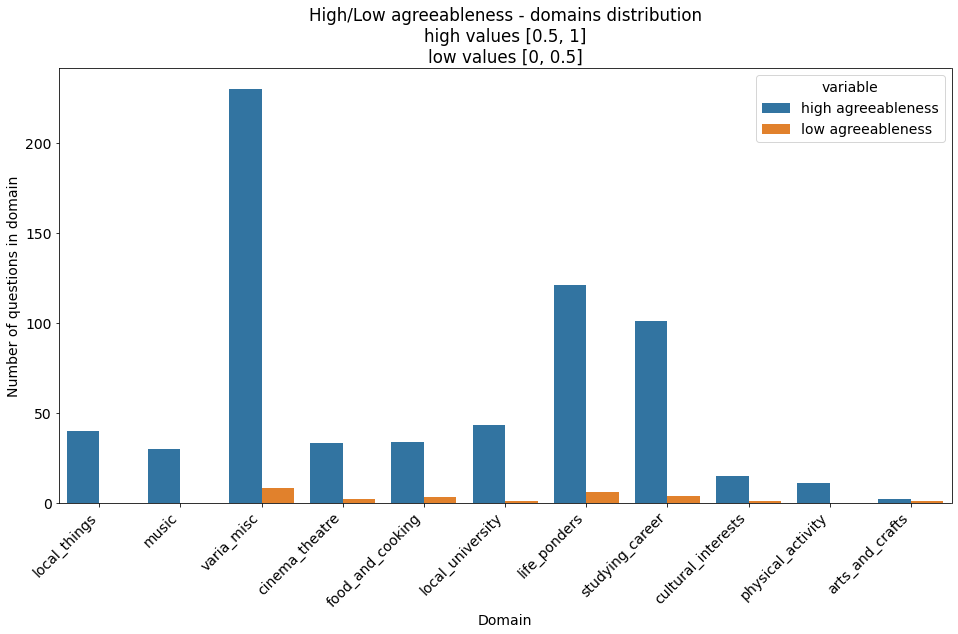

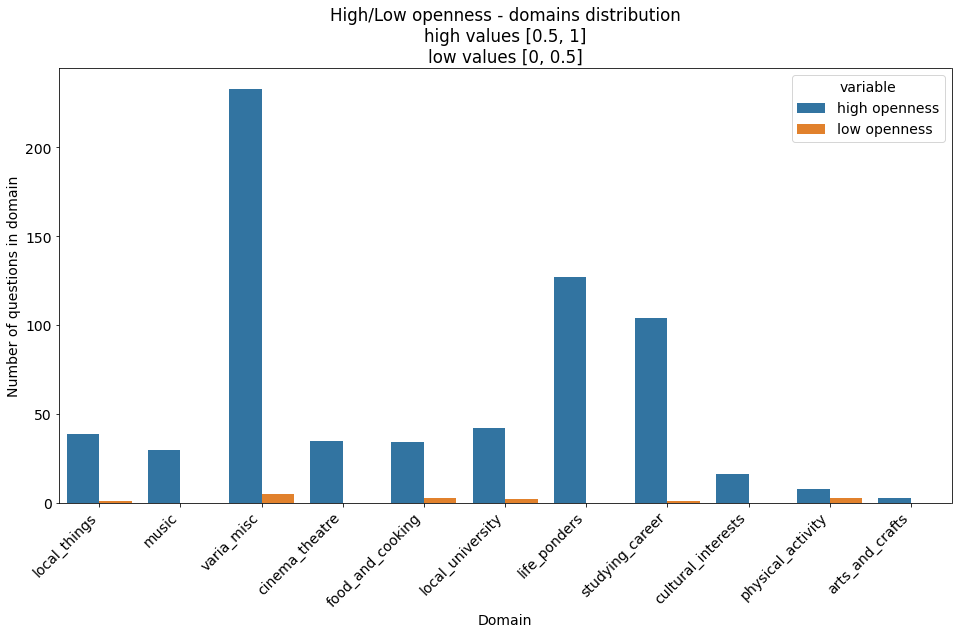

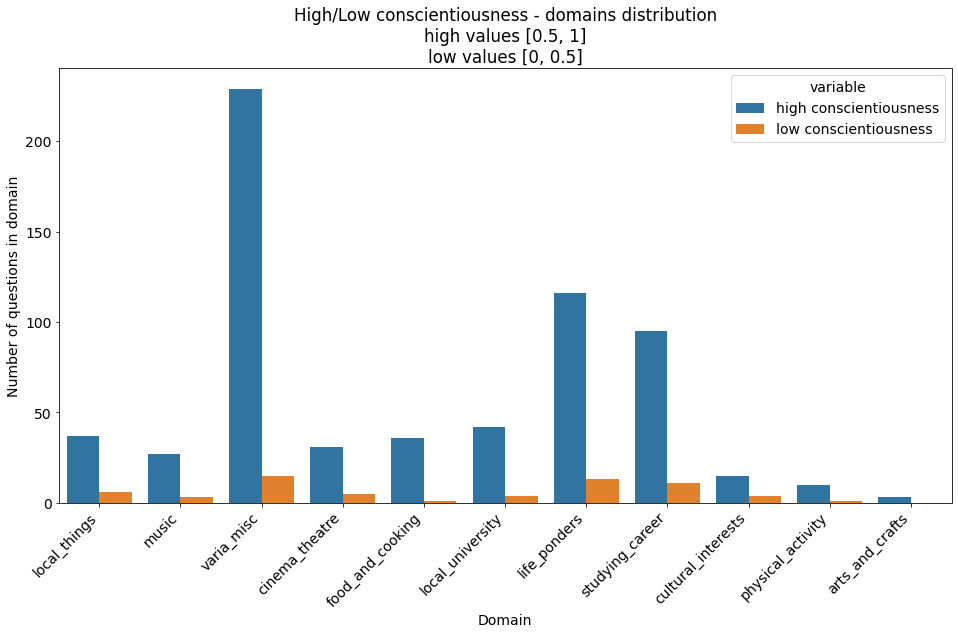

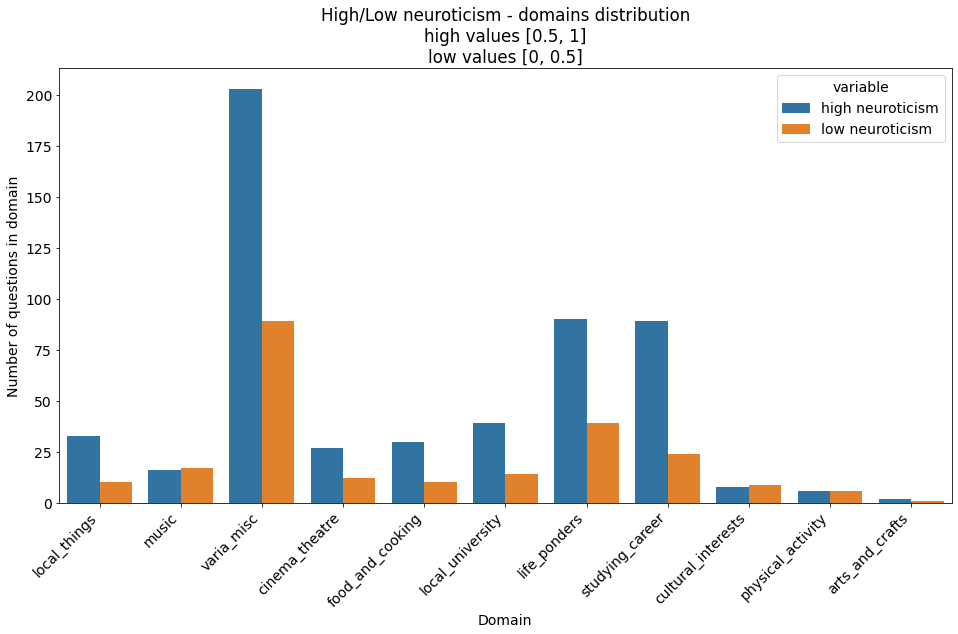

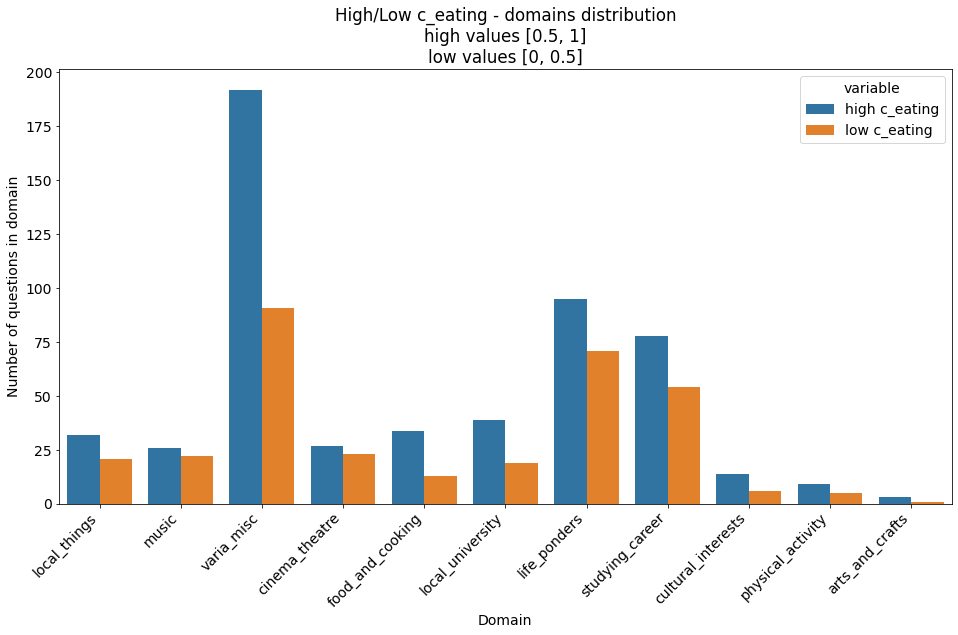

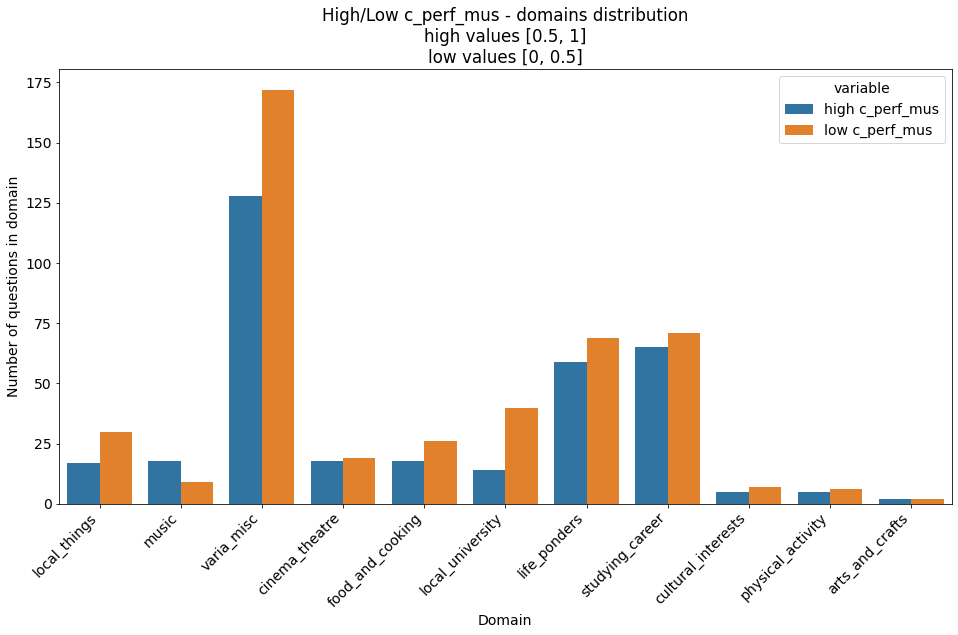

In [65]:
for feature in big_five_columns+['c_eating', 'c_perf_mus']:
    plot_feature_highlow_domains(feature, 0.5)

### G